In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])
])

In [3]:
source_dataset = datasets.ImageFolder(root='G:\\西电科研\\src\\py\\pythonProject\\' \
                                           '实现弱监督下的RM生成\\pytorch_DAN\\DAN\\data1\\sketch\\sketch', 
                                      transform=transform)
target_dataset = datasets.ImageFolder(root='G:\\西电科研\\src\\py\\pythonProject\\' \
                                           '实现弱监督下的RM生成\\pytorch_DAN\\DAN\\data1\\quickdraw\\quickdraw', 
                                      transform=transform)

In [4]:
print("Source Dataset:")
print(f"Number of samples: {len(source_dataset)}")
#print(f"Class labels: {source_dataset.classes}")
print(f"Number of classes: {len(source_dataset.classes)}")

print("\nTarget Dataset:")
print(f"Number of samples: {len(target_dataset)}")
#print(f"Class labels: {target_dataset.classes}")
print(f"Number of classes: {len(target_dataset.classes)}")


Source Dataset:
Number of samples: 70386
Number of classes: 345

Target Dataset:
Number of samples: 172500
Number of classes: 345


In [5]:
source_dataloader = DataLoader(dataset=source_dataset,batch_size=64,shuffle=True,drop_last=True)
target_dataloader = DataLoader(dataset=target_dataset,batch_size=64,shuffle=True,drop_last=True)

print("Source DataLoader:")
print(f"Batch size: {source_dataloader.batch_size}")
print(f"Number of batches: {len(source_dataloader)}")
print(f"Drop last: {source_dataloader.drop_last}")

print("\nTarget DataLoader:")
print(f"Batch size: {target_dataloader.batch_size}")
print(f"Number of batches: {len(target_dataloader)}")
print(f"Drop last: {target_dataloader.drop_last}")

Source DataLoader:
Batch size: 64
Number of batches: 1099
Drop last: True

Target DataLoader:
Batch size: 64
Number of batches: 2695
Drop last: True


In [6]:
for batch_idx, (data, target) in enumerate(source_dataloader):
    print("source_dataloader:")
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}")
    print(f"Target shape: {target.shape}")
    break

print(" ")
    
for batch_idx, (data, target) in enumerate(target_dataloader):
    print("target_dataloader:")
    print(f"Batch {batch_idx + 1}:")
    print(f"Data shape: {data.shape}")
    print(f"Target shape: {target.shape}")
    break    

source_dataloader:
Batch 1:
Data shape: torch.Size([64, 3, 227, 227])
Target shape: torch.Size([64])
 
target_dataloader:
Batch 1:
Data shape: torch.Size([64, 3, 227, 227])
Target shape: torch.Size([64])


In [7]:
import torchvision.models as models
import torch.nn as nn

In [10]:
alexnet = models.alexnet(weights=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pylab
import params

In [12]:
def pairwise_distance(x, y):

    if not len(x.shape) == len(y.shape) == 2:
        raise ValueError('Both inputs should be matrices.')

    if x.shape[1] != y.shape[1]:
        raise ValueError('The number of features should be the same.')

    x = x.view(x.shape[0], x.shape[1], 1)
    y = torch.transpose(y, 0, 1)
    output = torch.sum((x - y) ** 2, 1)
    output = torch.transpose(output, 0, 1)

    return output

In [13]:
def gaussian_kernel_matrix(x, y, sigmas):

    sigmas = sigmas.view(sigmas.shape[0], 1)
    beta = 1. / (2. * sigmas)
    dist = pairwise_distance(x, y).contiguous()
    dist_ = dist.view(1, -1)
    s = torch.matmul(beta, dist_)

    return torch.sum(torch.exp(-s), 0).view_as(dist)

In [14]:
def maximum_mean_discrepancy(x, y, kernel= gaussian_kernel_matrix):

    cost = torch.mean(kernel(x, x))
    cost += torch.mean(kernel(y, y))
    cost -= 2 * torch.mean(kernel(x, y))

    return cost

In [15]:
def mmd_loss(source_features, target_features):

    sigmas = [
        1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
        1e3, 1e4, 1e5, 1e6
    ]
   
    gaussian_kernel = partial(
            gaussian_kernel_matrix, sigmas = Variable(torch.cuda.FloatTensor(sigmas))
        )
   
    loss_value = maximum_mean_discrepancy(source_features, target_features, kernel= gaussian_kernel)
    loss_value = loss_value

    return loss_value

In [16]:
import torch
import torchvision
import numpy as np
from torch.autograd import Variable

import utils
import params
from tqdm import tqdm

momentum = 0.9
theta1 = 0.5
theta2 = 0.5
epochs = 100
lr = 0.001

In [20]:
common_net = models.AlexNet().features
src_net = models.AlexNet().classifier
tgt_net = models.AlexNet().classifier

for param in common_net[:8].parameters():
    param.requires_grad = False
    
for idx,layer in enumerate(common_net):
    print(f"Layer {idx}: {layer}")
    for param in layer.parameters():
        print(f"  requires_grad: {param.requires_grad}")

Layer 0: Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  requires_grad: False
  requires_grad: False
Layer 1: ReLU(inplace=True)
Layer 2: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 3: Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  requires_grad: False
  requires_grad: False
Layer 4: ReLU(inplace=True)
Layer 5: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
Layer 6: Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  requires_grad: False
  requires_grad: False
Layer 7: ReLU(inplace=True)
Layer 8: Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  requires_grad: True
  requires_grad: True
Layer 9: ReLU(inplace=True)
Layer 10: Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  requires_grad: True
  requires_grad: True
Layer 11: ReLU(inplace=True)
Layer 12: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [21]:
src_dataiter = iter(source_dataloader)
tgt_dataiter = iter(target_dataloader)
src_imgs, src_labels = next(src_dataiter)
tgt_imgs, tgt_labels = next(tgt_dataiter)

In [22]:
train_hist = {}
train_hist['Total_loss'] = []
train_hist['Class_loss'] = []
train_hist['MMD_loss'] = []

test_hist = {}
test_hist['Source Accuracy'] = []
test_hist['Target Accuracy'] = []


In [23]:
common_net.cuda()
src_net.cuda()
tgt_net.cuda()

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [24]:
import torch
from torch.autograd import Variable
from sklearn.manifold import TSNE
import numpy as np
from sklearn.decomposition import PCA

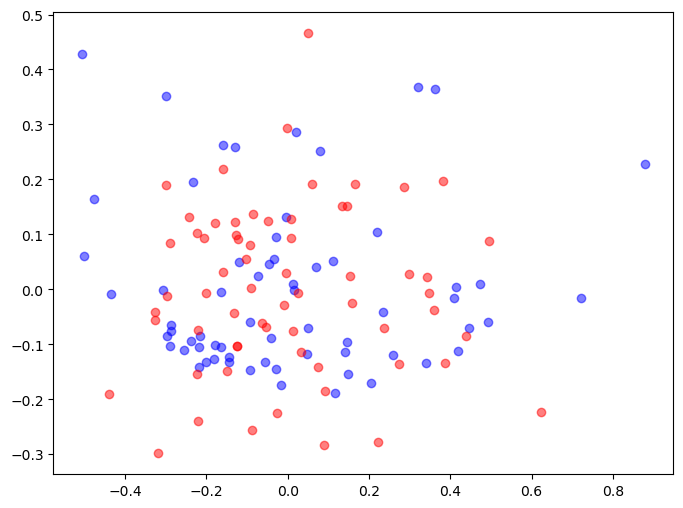

In [25]:
src_features = common_net(Variable(src_imgs.expand(src_imgs.shape[0], 3, 227, 227).cuda()))
tgt_features = common_net(Variable(tgt_imgs.expand(tgt_imgs.shape[0], 3, 227, 227).cuda()))



src_features = src_features.view(src_features.shape[0], -1)
tgt_features = tgt_features.view(tgt_features.shape[0], -1)

src_features = src_features.cpu().data.numpy()
tgt_features = tgt_features.cpu().data.numpy()

pca = PCA(n_components=2)
src_features_2d = pca.fit_transform(src_features)  # 降维
tgt_features_2d = pca.fit_transform(tgt_features)  # 降维

plt.figure(figsize=(8, 6))

# 绘制源特征，蓝色
plt.scatter(src_features_2d[:, 0], src_features_2d[:, 1], color='b', label='Source Features', alpha=0.5)

# 绘制目标特征，红色
plt.scatter(tgt_features_2d[:, 0], tgt_features_2d[:, 1], color='r', label='Target Features', alpha=0.5)

In [26]:
import torch.optim as optim

In [27]:
optimizer = optim.SGD([{'params': common_net.parameters()},
                       {'params': src_net.parameters()},
                       {'params': tgt_net.parameters()}], lr= params.lr, momentum= params.momentum)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
from tqdm import tqdm
import torch

def train(common_net, src_net, tgt_net, optimizer, criterion, epoch,
          source_dataloader, target_dataloader, train_hist, epochs):
    
    # 设置模型为训练模式
    common_net.train()
    src_net.train()
    tgt_net.train()
    
    # 设置步数
    start_steps = epoch * len(source_dataloader)
    total_steps = epochs * len(source_dataloader)
    
    source_iter = iter(source_dataloader)
    target_iter = iter(target_dataloader)
    
    # 使用 tqdm 包装训练数据集迭代器
    with tqdm(total=min(len(source_dataloader), len(target_dataloader)), 
              desc=f"Epoch {epoch + 1}/{epochs}") as pbar:
        for batch_idx in range(min(len(source_dataloader), len(target_dataloader))):
            
            sdata = next(source_iter)
            tdata = next(target_iter)
            
            input1, label1 = sdata
            input2, label2 = tdata
            
            input1, label1 = input1.cuda(), label1.cuda()
            input2, label2 = input2.cuda(), label2.cuda()
            
            optimizer.zero_grad()
            
            # 扩展输入数据大小
            input1 = input1.expand(input1.shape[0], 3, 227, 227)
            
            # 合并源数据和目标数据
            input = torch.cat((input1, input2), 0)
            
            # 提取特征
            common_feature = common_net(input)
            
            # 将特征按批次分割
            src_feature, tgt_feature = torch.split(common_feature, 64)
            
            # 展平特征
            src_feature = src_feature.view(src_feature.size(0), -1)
            tgt_feature = tgt_feature.view(tgt_feature.size(0), -1)
            
            # 源网络和目标网络的输出
            src_output = src_net(src_feature)
            tgt_output = tgt_net(tgt_feature)
            
            # 计算类别损失
            class_loss = criterion(src_output, label1)
            
            # 计算 MMD 损失
            mmd_losss = mmd_loss(src_feature, tgt_feature) * theta1 + mmd_loss(src_output, tgt_output) * theta2
            
            # 总损失
            loss = class_loss + mmd_losss
            loss.backward()
            
            # 优化器更新参数
            optimizer.step()
            
            # 将损失记录到历史
            train_hist['Total_loss'].append(loss.cpu().data.item())
            train_hist['Class_loss'].append(class_loss.cpu().data.item())
            train_hist['MMD_loss'].append(mmd_losss.cpu().data.item())
            
            # 更新 tqdm 显示的损失信息
            pbar.set_postfix({'Total Loss': loss.item(),
                              'Class Loss': class_loss.item(),
                              'MMD Loss': mmd_losss.item()})
            
            pbar.update(1)  # 更新进度条


In [ ]:
for epoch in range(100):
    train(common_net, src_net, tgt_net, optimizer, criterion,
                epoch, source_dataloader, target_dataloader, train_hist,epochs)

Epoch 1/100:  10%|████▌                                       | 113/1099 [06:01<40:05,  2.44s/it, Total Loss=6.96, Class Loss=6.3, MMD Loss=0.664]